# Part-1 
- Object Detection Using yolo 
- Yolo v1
- Group number S21DL20
-  Team members 
   - Korupoulu Saideepthi    S20180010087
   - Varakala Sowmya         S20180010187
   - Manjju Shree Devy       S20180010055
   - Swathi Kedarasetty      S20180010172

## Mounting to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/DL_assignment2"

/content/drive/MyDrive/DL_assignment2


## Downloading the PascalVoc dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
!mv VOCdevkit VOCdevkit_2007
!rm VOCtrainval_06-Nov-2007.tar

--2021-04-09 10:11:10--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  9.09MB/s    in 50s     

2021-04-09 10:12:01 (8.76 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar -xf VOCtest_06-Nov-2007.tar
!mv VOCdevkit/VOC2007 VOCdevkit_2007/VOC2007test
!rmdir VOCdevkit
!rm VOCtest_06-Nov-2007.tar

--2021-04-09 10:13:26--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  9.18MB/s    in 49s     

2021-04-09 10:14:15 (8.77 MB/s) - ‘VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



## Generate Labels for VOC {object-class x y width height}

In [8]:
#!python voc_label.py

## Importing necessary libraries

In [9]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## Resnet Model

In [12]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Hyperparameters

In [13]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading data

### VocDetectorDataset  is used for Data Augumentation
  - Reads Images from the path
  - Gets the bounding boxes , class predictions
  - Random shift
  - Random scale
  - Random crop
  - Random flip
  - Subtract mean
  - Encoder
     >function takes as input bounding boxes and corresponding labels for a particular image
        sample and outputs a target tensor of size SxSx(5xB+C) 
     >where S,S are the spatial dimensions, B is the number of bounding box predictions,
       C is the number of classes in the dataset and 5 represents the bounding box coordinates
   - getitem
     >All the above functions are put in this function to get the final augmentation images

In [15]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = '2007_train.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = '2007_test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Yolo Loss
  - Compute_iou (Intersection over union)
    > Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M]
  - forward
      > Args:
         pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30)
                      where B - number of bounding boxes this grid cell is a part of = 2
                            5 - number of bounding box values corresponding to [x, y, w, h, c]
                                where x - x_coord, y - y_coord, w - width, h - height, c - confidence of having an object
                            20 - number of classes
         target_tensor: (tensor) size(batchsize,S,S,30)
            
      - Compute loss for the cells with no object bbox
      - Compute loss for the cells with objects
      - Choose the predicted bbox having the highest IoU for each target bbox
      - BBox location/size and objectness loss for the response boxes
      - Class probability loss for the cells which contain objects
      - Total loss
      > Returns :
         Total Loss

In [14]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Training
  Used Resnet model

In [ ]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    torch.cuda.empty_cache()




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/DL_assignment2/yolo_loss.py:89: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])]
/content/drive/MyDrive/DL_assignment2/yolo_loss.py:90: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/Indexi

Epoch [1/50], Iter [5/209] Loss: 63.9866, average_loss: 74.1429
Epoch [1/50], Iter [10/209] Loss: 43.0308, average_loss: 62.8805
Epoch [1/50], Iter [15/209] Loss: 26.3950, average_loss: 52.0468
Epoch [1/50], Iter [20/209] Loss: 12.2670, average_loss: 43.2965
Epoch [1/50], Iter [25/209] Loss: 10.1667, average_loss: 37.1362
Epoch [1/50], Iter [30/209] Loss: 7.5710, average_loss: 32.5897
Epoch [1/50], Iter [35/209] Loss: 8.2788, average_loss: 29.3558
Epoch [1/50], Iter [40/209] Loss: 9.5561, average_loss: 26.7427
Epoch [1/50], Iter [45/209] Loss: 9.3577, average_loss: 24.6606
Epoch [1/50], Iter [50/209] Loss: 7.2940, average_loss: 23.0173
Epoch [1/50], Iter [55/209] Loss: 6.9428, average_loss: 21.5771
Epoch [1/50], Iter [60/209] Loss: 7.6639, average_loss: 20.3391
Epoch [1/50], Iter [65/209] Loss: 6.3257, average_loss: 19.2623
Epoch [1/50], Iter [70/209] Loss: 5.3851, average_loss: 18.3088
Epoch [1/50], Iter [75/209] Loss: 7.0248, average_loss: 17.5354
Epoch [1/50], Iter [80/209] Loss: 6.

## Mean Average Precision

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:23<00:00, 34.43it/s]


---class aeroplane ap 0.461997978943023---
---class bicycle ap 0.6359974440609961---
---class bird ap 0.47355089012157403---
---class boat ap 0.2862735768253211---
---class bottle ap 0.2091828800787261---
---class bus ap 0.6336731764541319---
---class car ap 0.6458709332098127---
---class cat ap 0.6858524443643779---
---class chair ap 0.315842207049645---
---class cow ap 0.5132370276353126---
---class diningtable ap 0.3388517367570423---
---class dog ap 0.6307587953970472---
---class horse ap 0.6760313169372795---
---class motorbike ap 0.5649322219448399---
---class person ap 0.5295174355939133---
---class pottedplant ap 0.1868921931047106---
---class sheep ap 0.4647626789384095---
---class sofa ap 0.4620061549727634---
---class train ap 0.6708275376684594---
---class tvmonitor ap 0.5022007930301944---
---map 0.4944129711543791---


## Testing on random images

predicting...


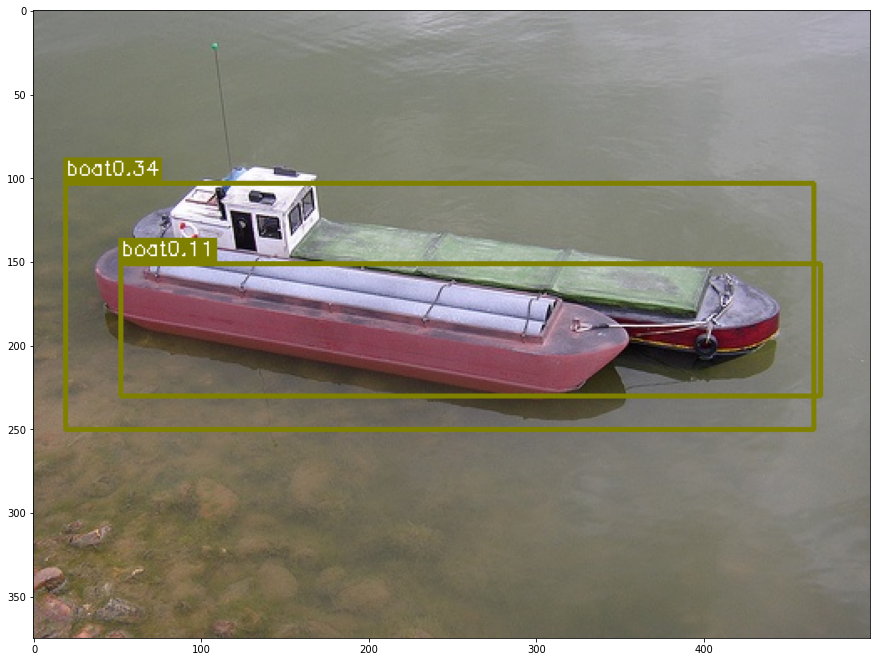

In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


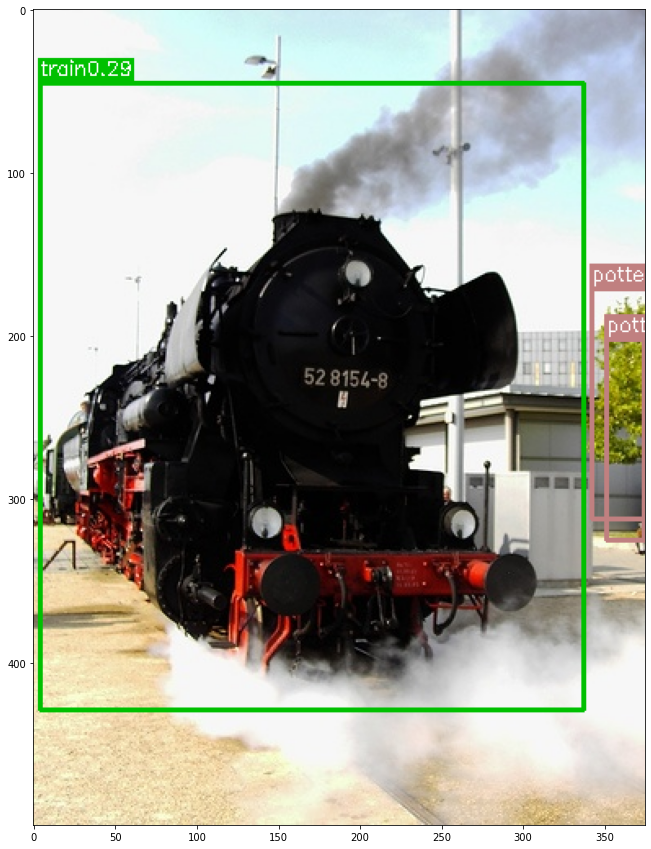

In [ ]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## References
 - https://araintelligence.com/blogs/deep-learning/object-detection/yolo_v1/
 - https://arxiv.org/pdf/1506.02640.pdf
 - https://pjreddie.com/darknet/yolo/